Background Subtraction

In [1]:
import os
from glob import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Path to the folder containing the frames
folder_path = '2011_09_26/2011_09_26_drive_0048_sync/image_00/data'

In [3]:
# get background subtractor
sub_type = 'MOG2' # 'MOG2'
if sub_type == "MOG2":
    backSub = cv2.createBackgroundSubtractorMOG2(varThreshold=16, detectShadows=False)
    # backSub.setShadowThreshold(0.75)
else:
    backSub = cv2.createBackgroundSubtractorKNN(dist2Threshold=1000, detectShadows=False)

In [4]:
image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]

In [5]:
image_paths[:5]

['2011_09_26/2011_09_26_drive_0048_sync/image_00/data\\0000000000.png',
 '2011_09_26/2011_09_26_drive_0048_sync/image_00/data\\0000000001.png',
 '2011_09_26/2011_09_26_drive_0048_sync/image_00/data\\0000000002.png',
 '2011_09_26/2011_09_26_drive_0048_sync/image_00/data\\0000000003.png',
 '2011_09_26/2011_09_26_drive_0048_sync/image_00/data\\0000000004.png']

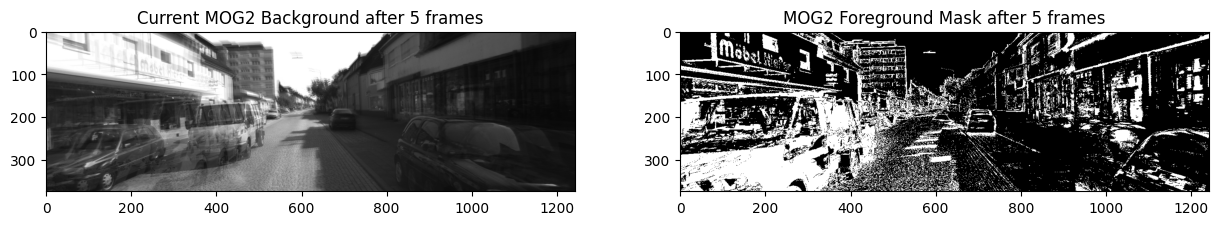

In [6]:
for img_path in image_paths[:5]:
    image = cv2.imread(img_path)
    # update the background model and obtain foreground mask
    fg_mask = backSub.apply(image)

# display
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(backSub.getBackgroundImage())
ax[0].set_title(f"Current {sub_type} Background after 5 frames")
ax[1].imshow(fg_mask, cmap='gray') 
ax[1].set_title(f"{sub_type} Foreground Mask after 5 frames");

In [7]:
from PIL import Image

def draw_bboxes(frame, detections):
    for det in detections:
        x1,y1,x2,y2 = det
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 3)

def create_gif_from_images(save_path : str, image_path : str, ext : str) -> None:
    ''' creates a GIF from a folder of images
        Inputs:
            save_path - path to save GIF
            image_path - path where images are located
            ext - extension of the images
        Outputs:
            None
    '''
    ext = ext.replace('.', '')
    image_paths = sorted(glob(os.path.join(image_path, f'*.{ext}')))
    image_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    pil_images = [Image.open(im_path) for im_path in image_paths]

    pil_images[0].save(save_path, format='GIF', append_images=pil_images,
                      save_all=True, duration=50, loop=0)

In [8]:
def get_motion_mask(fg_mask, min_thresh=0, kernel=np.array((9,9), dtype=np.uint8)):
    """ Obtains image mask
        Inputs: 
            fg_mask - foreground mask
            kernel - kernel for Morphological Operations
        Outputs: 
            mask - Thresholded mask for moving pixels
        """
    _, thresh = cv2.threshold(fg_mask,min_thresh,255,cv2.THRESH_BINARY)
    motion_mask = cv2.medianBlur(thresh, 3)
    
    # morphological operations
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    return motion_mask

In [9]:
def get_contour_detections(mask, thresh=400):
    """ Obtains initial proposed detections from contours discoverd on the mask. 
        Scores are taken as the bbox area, larger is higher.
        Inputs:
            mask - thresholded image mask
            thresh - threshold for contour size
        Outputs:
            detectons - array of proposed detection bounding boxes and scores [[x1,y1,x2,y2,s]]
        """
    # get mask contours
    contours, _ = cv2.findContours(mask, 
                                   cv2.RETR_EXTERNAL, # cv2.RETR_TREE, 
                                   cv2.CHAIN_APPROX_TC89_L1)
    detections = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area > thresh: 
            detections.append([x,y,x+w,y+h, area])

    return np.array(detections)

In [10]:
def remove_contained_bboxes(boxes):
    """ Removes all smaller boxes that are contained within larger boxes.
        Requires bboxes to be soirted by area (score)
        Inputs:
            boxes - array bounding boxes sorted (descending) by area 
                    [[x1,y1,x2,y2]]
        Outputs:
            keep - indexes of bounding boxes that are not entirely contained 
                   in another box
        """
    check_array = np.array([True, True, False, False])
    keep = list(range(0, len(boxes)))
    for i in keep: # range(0, len(bboxes)):
        for j in range(0, len(boxes)):
            # check if box j is completely contained in box i
            if np.all((np.array(boxes[j]) >= np.array(boxes[i])) == check_array):
                try:
                    keep.remove(j)
                except ValueError:
                    continue
    return keep

def non_max_suppression(boxes, scores, threshold=1e-1):
    """
    Perform non-max suppression on a set of bounding boxes and corresponding scores.
    Inputs:
        boxes: a list of bounding boxes in the format [xmin, ymin, xmax, ymax]
        scores: a list of corresponding scores 
        threshold: the IoU (intersection-over-union) threshold for merging bounding boxes
    Outputs:
        boxes - non-max suppressed boxes
    """
    # Sort the boxes by score in descending order
    boxes = boxes[np.argsort(scores)[::-1]]

    # remove all contained bounding boxes and get ordered index
    order = remove_contained_bboxes(boxes)

    keep = []
    while order:
        i = order.pop(0)
        keep.append(i)
        for j in order:
            # Calculate the IoU between the two boxes
            intersection = max(0, min(boxes[i][2], boxes[j][2]) - max(boxes[i][0], boxes[j][0])) * \
                           max(0, min(boxes[i][3], boxes[j][3]) - max(boxes[i][1], boxes[j][1]))
            union = (boxes[i][2] - boxes[i][0]) * (boxes[i][3] - boxes[i][1]) + \
                    (boxes[j][2] - boxes[j][0]) * (boxes[j][3] - boxes[j][1]) - intersection
            iou = intersection / union

            # Remove boxes with IoU greater than the threshold
            if iou > threshold:
                order.remove(j)
                
    return boxes[keep]

In [11]:
def get_detections(backSub, frame, bbox_thresh=100, nms_thresh=0.1, kernel=np.array((9,9), dtype=np.uint8)):
    """ Main function to get detections via Frame Differencing
        Inputs:
            backSub - Background Subtraction Model
            frame - Current BGR Frame
            bbox_thresh - Minimum threshold area for declaring a bounding box
            nms_thresh - IOU threshold for computing Non-Maximal Supression
            kernel - kernel for morphological operations on motion mask
        Outputs:
            detections - list with bounding box locations of all detections
                bounding boxes are in the form of: (xmin, ymin, xmax, ymax)
        """
    # Update Background Model and get foreground mask
    fg_mask = backSub.apply(frame)

    # get clean motion mask
    motion_mask = get_motion_mask(fg_mask, kernel=kernel)

    # get initially proposed detections from contours
    detections = get_contour_detections(motion_mask, bbox_thresh)

    # separate bboxes and scores
    bboxes = detections[:, :4]
    scores = detections[:, -1]

    # perform Non-Maximal Supression on initial detections
    return non_max_suppression(bboxes, scores, nms_thresh)

In [12]:
kernel=np.array((9,9), dtype=np.uint8)

In [13]:
for idx in range(0, len(image_paths)):
    # read frames
    frame_bgr = cv2.imread(image_paths[idx])

    # get detections
    detections = get_detections(backSub, 
                                cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY), 
                                bbox_thresh=100, 
                                nms_thresh=1e-2, 
                                kernel=kernel)
                                
    # draw bounding boxes on frame
    draw_bboxes(frame_bgr, detections)

    current_directory_path = os.getcwd()
    subfolder_path = os.path.join(current_directory_path, 'temp')
    
    # save image for GIF
    fig = plt.figure(figsize=(15, 7))
    plt.imshow(frame_bgr)
    plt.axis('off')
    file_path = os.path.join(subfolder_path, f"frame_{idx}.png")
    fig.savefig(file_path)
    plt.close();

In [14]:
create_gif_from_images('frame_differencing.gif', 'temp', '.png')